In [479]:
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date,datetime,timezone

In [480]:
data=pd.read_csv('weatherdata.csv')

In [481]:
data.drop(['timezone','dt_iso','city_name', 'lat', 'lon','feels_like', 'temp_min', 'temp_max','grnd_level','feels_like','rain_1h',
       'rain_3h', 'snow_1h', 'snow_3h', 'clouds_all', 'weather_id',
       'weather_main', 'weather_description', 'weather_icon','sea_level'], axis=1, inplace=True)

In [482]:
for i in range(len(data['dt'])):
    data['dt'].iloc[i]=datetime.utcfromtimestamp(data['dt'].iloc[i]).strftime('%Y-%m-%d %H:%M:%S')

data['dt']=pd.to_datetime(data['dt'])
data=data.set_index('dt')

C:\Users\rajat\anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [483]:
wind_data=data.drop(['temp','wind_deg','pressure'], axis=1)

In [484]:
wind_data.tail()

,humidity,wind_speed
dt,,
2020-05-31 19:00:00,72,3.1
2020-05-31 20:00:00,68,4.1
2020-05-31 21:00:00,68,2.6
2020-05-31 22:00:00,68,2.1
2020-05-31 23:00:00,68,2.1


In [485]:
date = '2020-05-01 00:00:00'
train=wind_data.loc[:date].copy()
test=wind_data[date:].copy()

In [486]:
train_date=np.array(train.index)
test_date=np.array(test.index)

In [487]:
def plot_sensor(name):
    
    plt.figure(figsize=(16,4))

    plt.plot(train_date, train[name], label='train')
    plt.plot(test_date, test[name], label='test')
    plt.ylabel(name); 
    plt.legend()
    plt.show()
    
def plot_autocor(name, df):
    
    plt.figure(figsize=(16,4))
    
    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()
    
    timeLags = np.arange(1,24*7)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

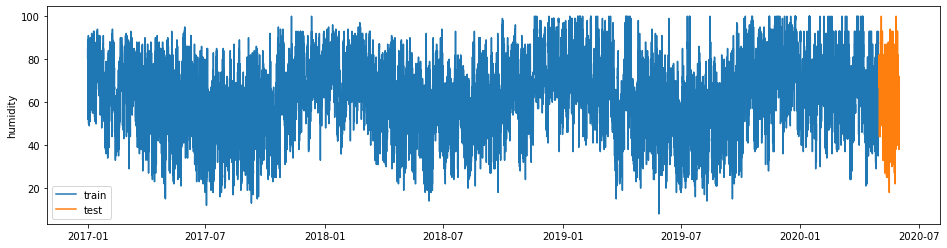

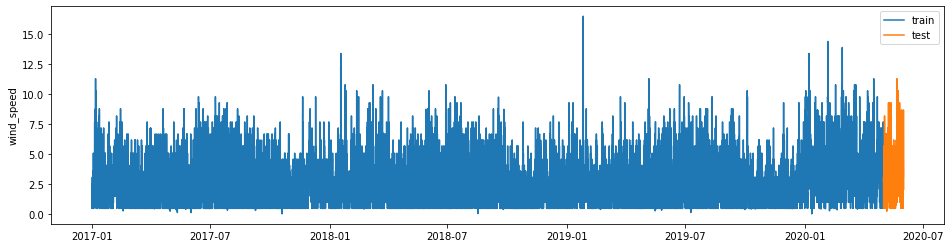

In [488]:
for col in wind_data.columns:
    plot_sensor(col)

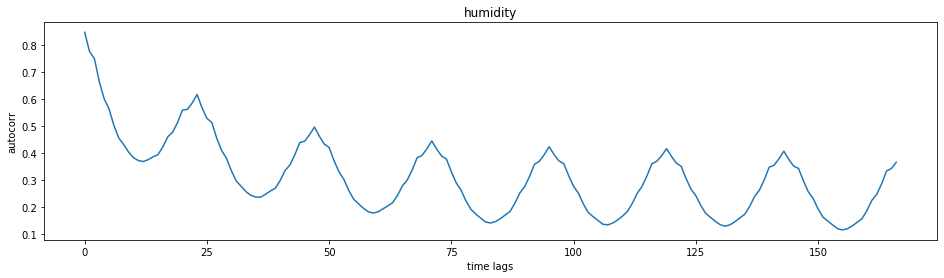

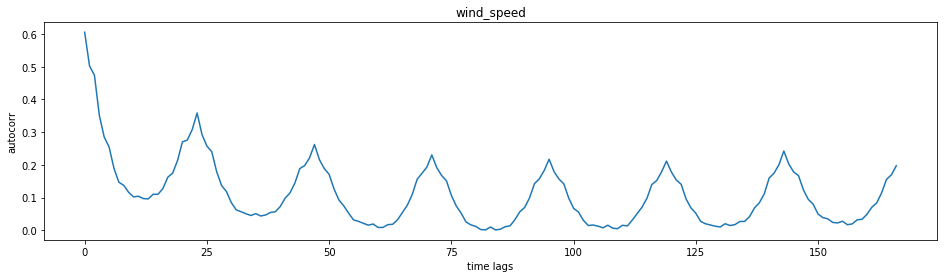

In [489]:
for col in wind_data.columns:
    plot_autocor(col, train)

In [490]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
result = adfuller(wind_data['humidity'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.300955
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [491]:
def cycle_encode(dat, cols):
    
    for col in cols:
        
        dat[col + '_sin'] = np.sin(2 * np.pi * dat[col]/dat[col].max())
        dat[col + '_cos'] = np.cos(2 * np.pi * dat[col]/dat[col].max())
        
    return dat

In [492]:
cyc_data=wind_data.copy()
cyc_data['month'] = wind_data.index.month
cyc_data['hour'] = wind_data.index.hour


cyc_data = cycle_encode(cyc_data, ['month','hour'])
cyc_data.drop(['month','hour'], axis=1, inplace=True)
train_cyc = cyc_data.iloc[:len(train)].copy()
test_cyc = cyc_data.iloc[len(train):].copy()
print(cyc_data.shape)
cyc_data.head()

(29939, 6)


,humidity,wind_speed,month_sin,month_cos,hour_sin,hour_cos
dt,,,,,,
2017-01-01 00:00:00,85,2.51,0.5,0.866025,0.000000,1.000000
2017-01-01 01:00:00,80,0.50,0.5,0.866025,0.269797,0.962917
2017-01-01 02:00:00,81,1.00,0.5,0.866025,0.519584,0.854419
2017-01-01 03:00:00,89,2.56,0.5,0.866025,0.730836,0.682553
2017-01-01 04:00:00,81,1.00,0.5,0.866025,0.887885,0.460065


In [493]:
period = 24

df_diff = wind_data.diff(period).dropna()
cyc_diff = cyc_data.diff(period).dropna()

In [494]:
train_diff = df_diff.iloc[:len(train)-period].copy()
test_diff = df_diff.iloc[len(train)-period:].copy()
train_cycd = cyc_diff.iloc[:len(train)-period].copy()
test_cycd = cyc_diff.iloc[len(train)-period:].copy()

In [495]:
train_cyc.columns

Index(['humidity', 'wind_speed', 'month_sin', 'month_cos', 'hour_sin',
       'hour_cos'],
      dtype='object')

In [496]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [497]:
AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,70):
    model = VAR(endog=train_cycd.values)
    model_result = model.fit(maxlags=i)
    try:
        AIC[i] = model_result.aic
    except:
        continue
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER 69 BEST AIC: -32.56082408451055


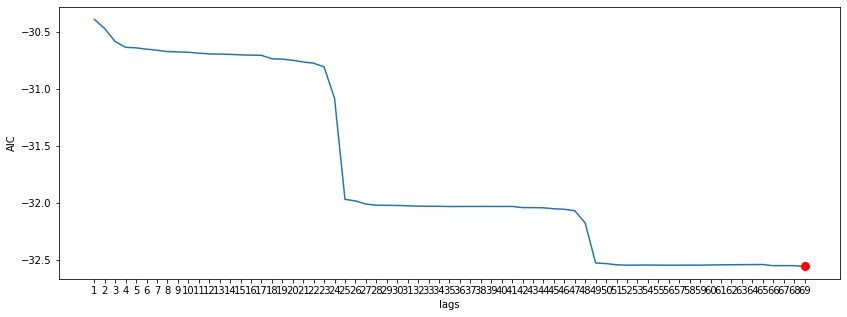

In [498]:
plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(len(AIC)), range(1,70))
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [499]:
var = VAR(endog=train_cycd.values)
var_result = var.fit(maxlags=best_order)
var_result.aic

-32.56082408451055

In [500]:
def retrive_prediction(prior, prior_init, steps):
    
    pred = var_result.forecast(np.asarray(prior), steps=steps)
    init = prior_init.tail(period).values
    
    if steps >period:
        id_period = list(range(period))*(steps//period)
        id_period = id_period + list(range(steps-len(id_period)))
    else:
        id_period = list(range(steps))
    
    final_pred = np.zeros((steps, prior.shape[1]))
    for j, (i,p) in enumerate(zip(id_period, pred)):
        final_pred[j] = init[i]+p
        init[i] = init[i]+p 
        
    return final_pred, pred

In [501]:
date = '2020-04-30 23:00:00'
forward = 72
date_range = pd.date_range(date, periods=forward+1, freq='H', closed='right')
print(date_range)

DatetimeIndex(['2020-05-01 00:00:00', '2020-05-01 01:00:00',
               '2020-05-01 02:00:00', '2020-05-01 03:00:00',
               '2020-05-01 04:00:00', '2020-05-01 05:00:00',
               '2020-05-01 06:00:00', '2020-05-01 07:00:00',
               '2020-05-01 08:00:00', '2020-05-01 09:00:00',
               '2020-05-01 10:00:00', '2020-05-01 11:00:00',
               '2020-05-01 12:00:00', '2020-05-01 13:00:00',
               '2020-05-01 14:00:00', '2020-05-01 15:00:00',
               '2020-05-01 16:00:00', '2020-05-01 17:00:00',
               '2020-05-01 18:00:00', '2020-05-01 19:00:00',
               '2020-05-01 20:00:00', '2020-05-01 21:00:00',
               '2020-05-01 22:00:00', '2020-05-01 23:00:00',
               '2020-05-02 00:00:00', '2020-05-02 01:00:00',
               '2020-05-02 02:00:00', '2020-05-02 03:00:00',
               '2020-05-02 04:00:00', '2020-05-02 05:00:00',
               '2020-05-02 06:00:00', '2020-05-02 07:00:00',
               '2020-05-

In [502]:
final_pred, pr = retrive_prediction(cyc_diff.loc[:date], cyc_data.loc[:date], steps = forward)
final_true = wind_data.loc[date_range]

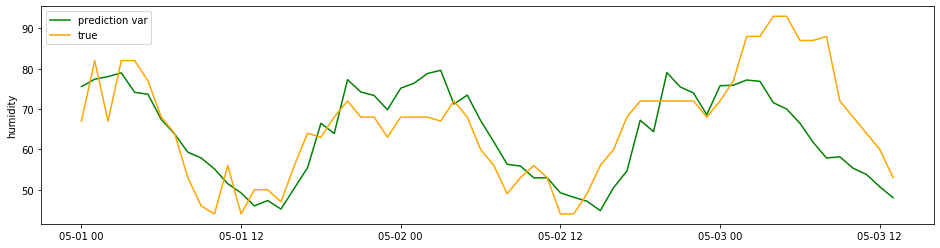

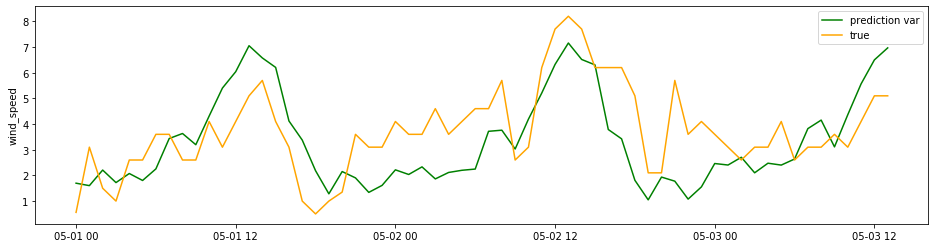

In [503]:
for i,col in enumerate(wind_data.columns):
    plt.figure(figsize=(16,4))
    plt.plot(date_range[:-10], final_pred[:,i][:-10], c='green', label='prediction var')
    #plt.plot(date_range, pr[:,i], c='red', label='pred')
    plt.plot(date_range[:-10], final_true[col].values[:-10], c='orange', label='true')
    plt.ylabel(col); plt.legend()
    plt.show()

In [505]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(final_true.values[:,-1], final_pred[:,1])
rmse = sqrt(mse)
print(rmse)

1.4709082659903223


In [506]:
wind_speed=np.power(final_pred[:,1],3)
pressure=data.loc[date_range]['pressure'].values
temp=data.loc[date_range]['temp'].values+273

In [507]:
R=2.90515100
air_density=np.multiply(temp,R).astype(float)
air_density=np.divide(pressure,air_density).astype(float)

In [508]:
A=3.14*55*55
constant=A*0.5*1.173*0.5
power_op=np.multiply(wind_speed,constant)

In [517]:
power_data=pd.DataFrame(list(zip(power_op,final_pred[:,1])), columns=['Calc_power','Wind_speed'])

In [518]:
power_data

,Calc_power,Wind_speed
0,13610.818128,1.696929
1,11442.570597,1.601561
2,29990.534247,2.208159
3,14185.144123,1.720469
4,24847.824758,2.073951
...,...,...
67,5737.730279,1.272377
68,23858.706112,2.046058
69,19066.798568,1.898723
70,6736.507255,1.342293


In [519]:
power_data.to_json(r'power_output.json')